<a href="https://colab.research.google.com/github/Natural-Language-Processing-SS24/task2/blob/main/Sentiment-Training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment-Analyse

In [1]:
!pip install transformers[torch]
!pip install pyspellchecker
!pip install transformers gradio
!pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## Umgebungseinstellung

In [2]:
# Google Colab spezifische Importe
from google.colab import files
from google.colab import drive

# Datenverarbeitung und Modelltraining
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Transformer Modelle und Tokenizer
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    GPT2Tokenizer, GPT2ForSequenceClassification,
    BartTokenizer, BartForSequenceClassification,
    T5Tokenizer, T5ForConditionalGeneration, AdamW,
    Trainer, TrainingArguments
)

# PyTorch Bibliotheken
import torch
from torch.utils.data import DataLoader, Dataset

# Weitere Bibliotheken
from tqdm import tqdm
import gradio as gr
import docx
from collections import Counter
import re
from multiprocessing import Pool
import matplotlib.pyplot as plt

## Daten hochladen und laden

In [3]:
# Funktion zum Hochladen von Dateien in Google Colab
def upload_files():
    uploaded = files.upload()
    return uploaded

# CSV-Datei laden
uploaded = upload_files()
train_data = pd.read_csv('Sentiment_Training.csv', delimiter=';')
test_data = pd.read_csv('Sentiment_Test.csv', delimiter=';')

Saving Sentiment_Test.csv to Sentiment_Test.csv
Saving Sentiment_Training.csv to Sentiment_Training.csv


## Explorative Datenanalyse

Erste Zeilen des Trainingsdatensatzes:
   label                                               text
0      4  I stalk this truck.  I've been to industrial p...
1      2  who really knows if this is good pho or not, i...
2      4  I LOVE Bloom Salon... all of their stylist are...
3      0  We were excited to eat here, it is difficult t...
4      2  So this is a place, with food. That much canno...

Informationen zum Trainingsdatensatz:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Statistik der Textlängen im Trainingsdatensatz:
count    10000.000000
mean       729.239800
std        653.262897
min          2.000000
25%        283.000000
50%        544.000000
75%        968.000000
max       5015.000000
Name: text_length, dtype: flo

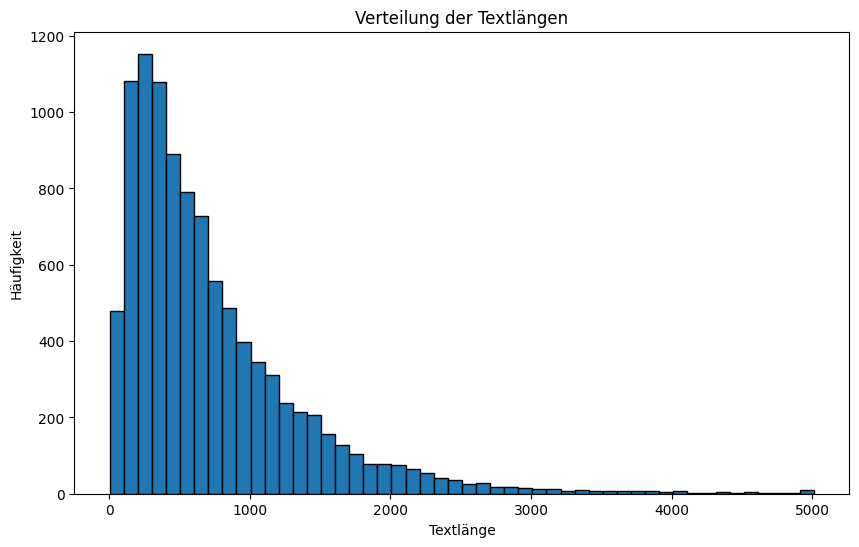


Verteilung der Labels im Trainingsdatensatz:
label
0    2035
1    1977
2    1943
3    1991
4    2054
Name: count, dtype: int64


In [4]:
# Anzeigen der ersten Zeilen und Informationen
print("Erste Zeilen des Trainingsdatensatzes:")
print(train_data.head())

print("\nInformationen zum Trainingsdatensatz:")
print(train_data.info())

# Textlänge berechnen
train_data['text_length'] = train_data['text'].apply(len)
print("\nStatistik der Textlängen im Trainingsdatensatz:")
print(train_data['text_length'].describe())

# Histogramm der Textlängen
plt.figure(figsize=(10, 6))
plt.hist(train_data['text_length'], bins=50, edgecolor='black')
plt.title('Verteilung der Textlängen')
plt.xlabel('Textlänge')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung der Labels
print("\nVerteilung der Labels im Trainingsdatensatz:")
print(train_data['label'].value_counts().sort_index())

## Slang-Wörterbuch laden

In [5]:
# Funktion zum Lesen der Word-Datei und Erstellen eines Slang-Wörterbuchs
def read_slang_dict_from_docx(docx_file):
    doc = docx.Document(docx_file)
    slang_dict = {}
    for para in doc.paragraphs:
        if ':' in para.text:
            key, value = para.text.split(':', 1)
            slang_dict[key.strip().lower()] = value.strip().lower()
    return slang_dict

# Word-Datei hochladen und lesen
uploaded = upload_files()
docx_file = 'abbreviations.docx'
slang_dict = read_slang_dict_from_docx(docx_file)
print("Slang Dictionary:", slang_dict)

Saving abbreviations.docx to abbreviations.docx
Slang Dictionary: {'u': 'you', 'ur': 'your', 'r': 'are', 'idk': 'i don’t know', 'btw': 'by the way', 'omg': 'oh my god', 'lol': 'laugh out loud', 'brb': 'be right back', 'gtg': 'got to go', 'smh': 'shaking my head', 'tbh': 'to be honest', 'wth': 'what the heck', 'rofl': 'rolling on the floor laughing', 'stfu': 'shut the fuck up', 'icymi': 'in case you missed it', 'tl;dr': 'too long, didn’t read', 'tmi': 'too much information', 'afaik': 'as far as i know', 'lmk': 'let me know', 'nvm': 'nevermind', 'ftw': 'for the win', 'byob': 'bring your own beer', 'bogo': 'buy one get one', 'jk': 'just kidding', 'jw': 'just wondering', 'tgif': 'thank goodness it’s friday', 'tbf': 'to be frank', 'rn': 'right now', 'fubar': 'fucking up beyond all recognition', 'iso': 'in search of', 'brt': 'be right there', 'ftfy': 'fixed that for you', 'gg': 'good game', 'bfd': 'big freaking deal', 'irl': 'in real life', 'dae': 'does anyone else?', 'ngl': 'not gonna lie',

In [6]:
def find_slang_words(df, slang_dict):
    slang_words_found = []

    for text in df['text']:
        words = text.split()
        for word in words:
            if word.lower() in slang_dict:
                slang_words_found.append(word.lower())

    return Counter(slang_words_found)

# Finden von Slang-Wörtern im Trainingsdatensatz
slang_words_counter = find_slang_words(train_data, slang_dict)

# Anzeige der Slang-Wörter und ihrer Häufigkeit
print(slang_words_counter)

Counter({'u': 116, 'im': 94, 'bf': 72, 'pm': 63, 'lol': 41, 'bc': 33, 'gf': 32, 'r': 22, 'til': 17, 'ur': 16, 'fyi': 15, 'omg': 15, 'aka': 12, 'wtf': 10, 'btw': 8, 'abt': 7, 'x': 7, 'wth': 6, 'diy': 6, 'cob': 5, 'imo': 5, 'tgif': 4, 'smh': 3, 'idk': 3, 'asap': 3, 'byob': 3, 'bogo': 3, 'imho': 3, 'jk': 2, 'wa': 2, 'tlc': 2, 'fb': 2, 'pov': 1, 'sc': 1, 'n/a': 1, 'bfd': 1, 'pda': 1, 'tia': 1, 'mms': 1, 'ff': 1, 'tt': 1, 'stfu': 1, 'lmao': 1, 'np': 1, 'sms': 1, 'tmi': 1, 'w/e': 1})


## Textvorverarbeitung

In [7]:
# Preprocessing-Funktion
def preprocess_text(text, slang_dict):
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    new_words = [slang_dict.get(word.lower(), word) for word in words]
    text = ' '.join(new_words)
    return text

def preprocess_text_parallel(text):
    return preprocess_text(text, slang_dict)

## Datenvorbereitung

In [8]:
# Funktion zur Kategorisierung der Sternebewertungen
def categorize_rating(rating):
    if rating <= 1:
        return 'negative'
    elif rating == 2:
        return 'neutral'
    else:
        return 'positive'

# Anwenden der Funktion auf die Trainings- und Testdaten
train_data['sentiment'] = train_data['label'].apply(categorize_rating)
test_data['sentiment'] = test_data['label'].apply(categorize_rating)

In [9]:
# Trainingsdaten in Trainings- und Validierungsdatensätze aufteilen
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['sentiment'], random_state=42)

## Dataset und Tokenisierung

In [10]:
# Dataset-Klasse definieren
class YelpDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        item['labels'] = self.labels[idx]
        return item

# Funktion zum Tokenisieren der Daten
def tokenize_data(data, tokenizer, slang_dict, model_name=None, max_length=10): #max_length auf 128 anpassen im finalen Lauf
    with Pool() as pool:
        texts = pool.map(preprocess_text_parallel, data['text'].tolist())
    labels = pd.Categorical(data['sentiment']).codes

    if model_name == 'T5':
        inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        targets = ["positive" if label == 2 else "neutral" if label == 1 else "negative" for label in labels]
        target_inputs = tokenizer(targets, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        return inputs, target_inputs.input_ids
    else:
        inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        return inputs, labels

## Modelle definieren

In [11]:
# Tokenizer und Modelle definieren
model_configs = {
    'BERT': {
        'tokenizer': BertTokenizer.from_pretrained('bert-base-uncased'),
        'model': BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    },
    'RoBERTa': {
        'tokenizer': RobertaTokenizer.from_pretrained('roberta-base'),
        'model': RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
    },
    'DistilBERT': {
        'tokenizer': DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
        'model': DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
    },
    'GPT-2': {
        'tokenizer': GPT2Tokenizer.from_pretrained('gpt2'),
        'model': GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=3)
    },
    'BART': {
        'tokenizer': BartTokenizer.from_pretrained('facebook/bart-base'),
        'model': BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=3)
    },
    'T5': {
        'tokenizer': T5Tokenizer.from_pretrained('t5-base'),
        'model': T5ForConditionalGeneration.from_pretrained('t5-base')
    }
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Training und Evaluierung

In [12]:
# Ensure all tokenizers have a pad_token and adjust models
for model_name, config in model_configs.items():
    tokenizer = config['tokenizer']
    model = config['model']

    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))

    # Explicitly set the pad_token_id for models that require it
    model.config.pad_token_id = tokenizer.pad_token_id
    assert tokenizer.pad_token is not None, f"Pad token not added for {model_name}"

# Optimizer definieren
def get_optimizer(model):
    return AdamW(model.parameters(), lr=5e-5)

# Trainingsschleife mit Gewichtung
def train(model, train_loader, optimizer, device, class_weights, model_name=None):
    model.train()
    total_loss = 0
    class_weights = class_weights.to(device)
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        if model_name == 'T5':
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        else:
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            weighted_loss = loss * class_weights[labels]
            weighted_loss = weighted_loss.mean()
            weighted_loss.backward()
            optimizer.step()
            total_loss += weighted_loss.item()
    return total_loss / len(train_loader)

# Evaluierungsschleife
def evaluate(model, val_loader, device, tokenizer, model_name=None):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            if model_name == 'T5':
                outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
                preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
                true_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
                loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
                total_loss += loss.item()
                correct_predictions += sum([1 if pred.strip() == true_label.strip() else 0 for pred, true_label in zip(preds, true_labels)])
                pred_labels = [2 if pred.strip() == "positive" else 1 if pred.strip() == "neutral" else 0 for pred in preds]
                true_label_ids = [2 if true_label.strip() == "positive" else 1 if true_label.strip() == "neutral" else 0 for true_label in true_labels]
                all_preds.extend(pred_labels)
                all_labels.extend(true_label_ids)
            else:
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct_predictions += torch.sum(preds == labels).item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
    accuracy = correct_predictions / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy, all_labels, all_preds

## Modelle trainieren und speichern

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Training BERT - Epoch 1/1


100%|██████████| 125/125 [00:01<00:00, 75.46it/s]


Train Loss: 1.1605, Val Loss: 0.9145, Val Accuracy: 0.5425

Confusion Matrix for BERT:
[[407   3 392]
 [117  10 262]
 [141   0 668]]

Classification Report for BERT:
              precision    recall  f1-score   support

    negative       0.61      0.51      0.55       802
     neutral       0.77      0.03      0.05       389
    positive       0.51      0.83      0.63       809

    accuracy                           0.54      2000
   macro avg       0.63      0.45      0.41      2000
weighted avg       0.60      0.54      0.49      2000



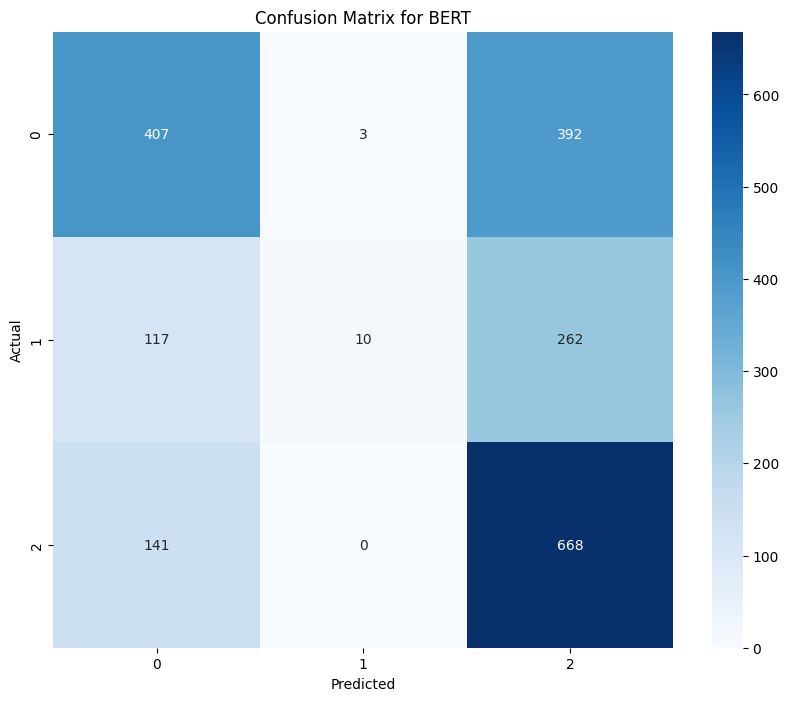

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Training RoBERTa - Epoch 1/1


100%|██████████| 125/125 [00:01<00:00, 78.68it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2702, Val Loss: 1.0539, Val Accuracy: 0.4045

Confusion Matrix for RoBERTa:
[[  0   0 802]
 [  0   0 389]
 [  0   0 809]]

Classification Report for RoBERTa:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       802
     neutral       0.00      0.00      0.00       389
    positive       0.40      1.00      0.58       809

    accuracy                           0.40      2000
   macro avg       0.13      0.33      0.19      2000
weighted avg       0.16      0.40      0.23      2000



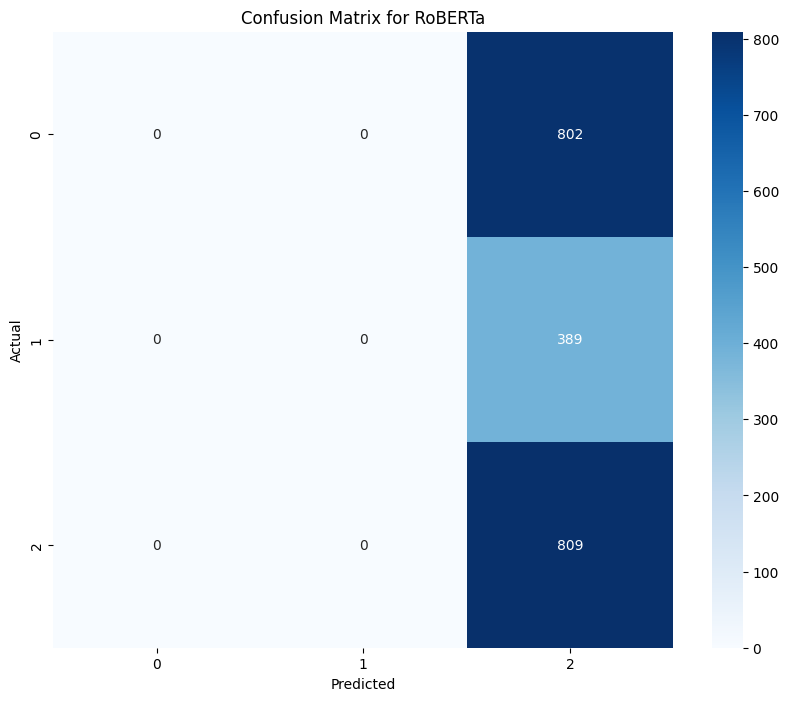

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Training DistilBERT - Epoch 1/1


100%|██████████| 125/125 [00:00<00:00, 128.94it/s]


Train Loss: 1.1152, Val Loss: 0.8780, Val Accuracy: 0.5760

Confusion Matrix for DistilBERT:
[[638  13 151]
 [226  34 129]
 [317  12 480]]

Classification Report for DistilBERT:
              precision    recall  f1-score   support

    negative       0.54      0.80      0.64       802
     neutral       0.58      0.09      0.15       389
    positive       0.63      0.59      0.61       809

    accuracy                           0.58      2000
   macro avg       0.58      0.49      0.47      2000
weighted avg       0.58      0.58      0.54      2000



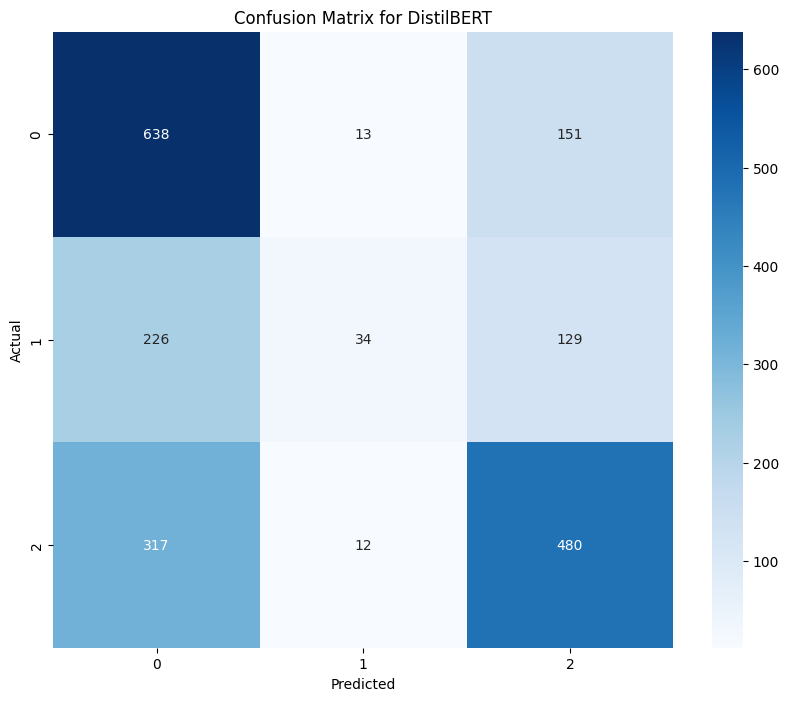

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Training GPT-2 - Epoch 1/1


100%|██████████| 125/125 [00:01<00:00, 70.09it/s]


Train Loss: 1.1926, Val Loss: 0.8866, Val Accuracy: 0.5625

Confusion Matrix for GPT-2:
[[470  36 296]
 [133  44 212]
 [178  20 611]]

Classification Report for GPT-2:
              precision    recall  f1-score   support

    negative       0.60      0.59      0.59       802
     neutral       0.44      0.11      0.18       389
    positive       0.55      0.76      0.63       809

    accuracy                           0.56      2000
   macro avg       0.53      0.48      0.47      2000
weighted avg       0.55      0.56      0.53      2000



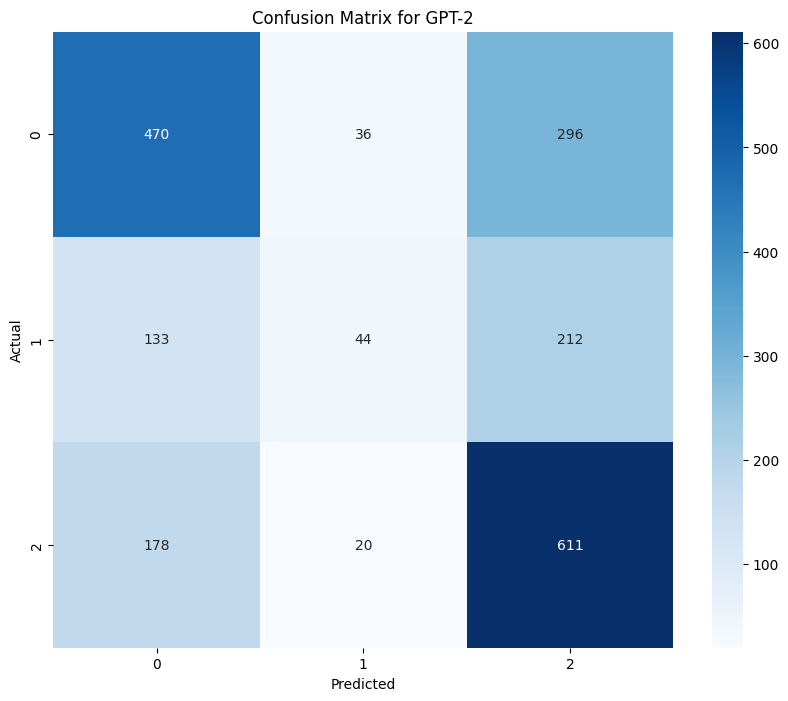

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.w

Training BART - Epoch 1/1


100%|██████████| 125/125 [00:02<00:00, 55.90it/s]


Train Loss: 1.1479, Val Loss: 0.8657, Val Accuracy: 0.5735

Confusion Matrix for BART:
[[504  37 261]
 [162  40 187]
 [175  31 603]]

Classification Report for BART:
              precision    recall  f1-score   support

    negative       0.60      0.63      0.61       802
     neutral       0.37      0.10      0.16       389
    positive       0.57      0.75      0.65       809

    accuracy                           0.57      2000
   macro avg       0.51      0.49      0.47      2000
weighted avg       0.54      0.57      0.54      2000



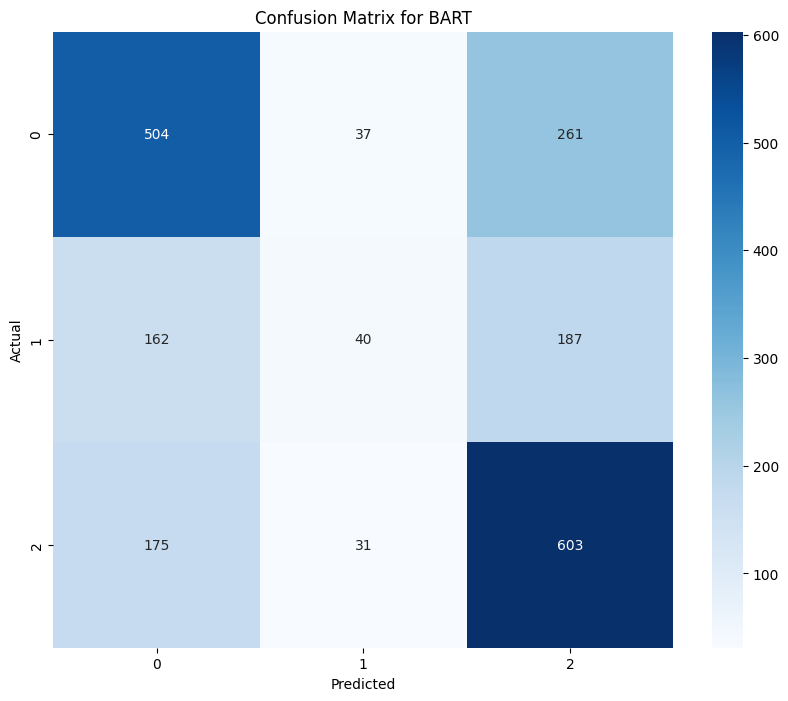

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-10-b151296c012d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long)
/usr/local/lib/pyt

Training T5 - Epoch 1/1


100%|██████████| 125/125 [00:12<00:00,  9.79it/s]


Train Loss: 0.9879, Val Loss: 0.4468, Val Accuracy: 0.5730

Confusion Matrix for T5:
[[552 102 148]
 [172 100 117]
 [235  80 494]]

Classification Report for T5:
              precision    recall  f1-score   support

    negative       0.58      0.69      0.63       802
     neutral       0.35      0.26      0.30       389
    positive       0.65      0.61      0.63       809

    accuracy                           0.57      2000
   macro avg       0.53      0.52      0.52      2000
weighted avg       0.56      0.57      0.56      2000



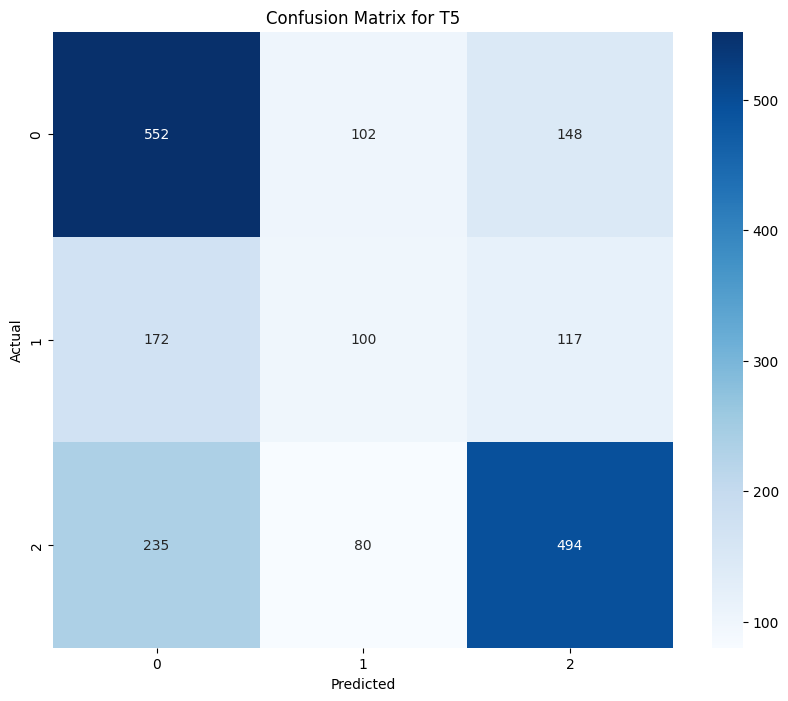

In [13]:
for model_name, config in model_configs.items():
    tokenizer = config['tokenizer']
    model = config['model']

    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))

    assert tokenizer.pad_token is not None, f"Pad token not added for {model_name}"

# Klassen-Gewichtungen
class_weights = torch.tensor([1.0, 2.0, 1.0])

trained_models = {}
for model_name, config in model_configs.items():
    tokenizer = config['tokenizer']
    model = config['model']

    # Tokenisieren der Trainings-, Validierungs- und Testdaten
    train_inputs, train_labels = tokenize_data(train_data, tokenizer, slang_dict, model_name)
    val_inputs, val_labels = tokenize_data(val_data, tokenizer, slang_dict, model_name)
    test_inputs, test_labels = tokenize_data(test_data, tokenizer, slang_dict, model_name)

    # Daten in Dataset-Objekte umwandeln
    train_dataset = YelpDataset(train_inputs, train_labels)
    val_dataset = YelpDataset(val_inputs, val_labels)
    test_dataset = YelpDataset(test_inputs, test_labels)

    # DataLoader erstellen
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Modell auf GPU/CPU laden
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer definieren
    optimizer = get_optimizer(model)

    # Training und Evaluierung
    epochs = 1 #Final auf 3 erhöhen
    for epoch in range(epochs):
        print(f"Training {model_name} - Epoch {epoch + 1}/{epochs}")
        train_loss = train(model, train_loader, optimizer, device, class_weights, model_name)
        val_loss, val_accuracy, val_labels, val_preds = evaluate(model, val_loader, device, tokenizer, model_name)
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Berechnung der Evaluationsmetriken
    conf_matrix = confusion_matrix(val_labels, val_preds)
    class_report = classification_report(val_labels, val_preds, target_names=['negative', 'neutral', 'positive'])

    print(f"\nConfusion Matrix for {model_name}:")
    print(conf_matrix)

    print(f"\nClassification Report for {model_name}:")
    print(class_report)

    # Confusion Matrix plotten
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Modell speichern
    trained_models[model_name] = {
        'model': model,
        'tokenizer': tokenizer,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report
    }

## Gradio-Oberfläche erstellen

In [14]:
# Gradio-Oberfläche erstellen
def classify_text(text):
    results = {}
    for model_name, model_info in trained_models.items():
        model = model_info['model']
        tokenizer = model_info['tokenizer']

        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        if model_name == 'T5':
            outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=128)
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            outputs = model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=1).item()
            sentiments = {0: 'negative', 1: 'neutral', 2: 'positive'}
            prediction = sentiments[prediction]

        results[model_name] = prediction

    return results

# Satz auswählen und Ergebnisse anzeigen
def get_test_sentence(index):
    try:
        index = int(index.split(":")[0])
        text = test_data.iloc[index]['text']
        original_label = test_data.iloc[index]['sentiment']
        return text, original_label
    except Exception as e:
        print(f"Error in get_test_sentence: {e}")
        return "", ""

def get_results_for_test_sentence(index):
    try:
        print(f"Selected index: {index}")
        text, original_label = get_test_sentence(index)
        if text == "":
            return {"error": "Invalid index or text not found"}, ""
        results = classify_text(text)
        results['Original Label'] = original_label
        return results, text
    except Exception as e:
        print(f"Error in get_results_for_test_sentence: {e}")
        return {"error": "An error occurred"}, ""

# Gradio-Komponente für den Satz-Picker
sentence_picker = gr.Dropdown(
    choices=[f"{i}: {text[:50]}" for i, text in enumerate(test_data['text'])],
    label="Wähle einen Satz aus dem Testdatensatz",
    interactive=True
)

# Gradio-Oberfläche erstellen
interface = gr.Interface(
    fn=get_results_for_test_sentence,
    inputs=sentence_picker,
    outputs=[gr.Json(label="Ergebnisse"), gr.Textbox(label="Selected Text")],
    title="Ergebnisse für einen Satz aus dem Testdatensatz"
)

# Starten der Gradio-Oberfläche
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://19951cfe2c6e5696b6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
